In [1]:
import tensorpac
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorpac import EventRelatedPac
from tensorpac.signals import pac_signals_wavelet

%matplotlib qt

In [2]:
group = 'Y'
group_save_path = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\{group} group'
figs_dir = os.path.join(group_save_path, 'sensors', 'figs', 'TF')
sub_name = 'ALL_subs'
task = '_BL'
task_stage = '_plan'
block_name = ''
epochs_all_subs = mne.read_epochs(os.path.join(group_save_path, f"{group}_{sub_name}{task}_epochs{task_stage}{block_name}_ALL-epo.fif"), preload=True)
epochs_all_subs.apply_baseline(baseline=(-0.5, -0.001))
epochs_all_subs

Reading D:\BonoKat\research project\# study 1\eeg_data\set\Y group\Y_ALL_subs_BL_epochs_plan_ALL-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 13 columns
2534 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Applying baseline correction (mode: mean)


<EpochsFIF | 2534 events (all good), -0.5 – 0.5 s (baseline -0.5 – -0.001 s), ~590.9 MiB, data loaded, with metadata,
 'prepare': 2534>

In [3]:
epo_data = epochs_all_subs.get_data()
epo_data

array([[[ 6.06349031e-06,  8.28359974e-06,  7.40728607e-06, ...,
         -9.63624003e-06, -6.49747324e-06, -8.76205256e-06],
        [-5.43950551e-06, -2.26412769e-06, -1.75776153e-07, ...,
         -1.02983617e-05, -9.71734034e-06, -1.05917005e-05],
        [ 9.82062907e-06,  1.12577018e-05,  9.87183183e-06, ...,
         -5.10129976e-06, -4.67482706e-06, -5.60384559e-06],
        ...,
        [-3.76883435e-06, -3.76258661e-06, -1.19797004e-06, ...,
          6.70771694e-06,  7.45897010e-06,  9.50354480e-06],
        [-5.25527335e-06, -4.46130374e-06, -8.22722401e-07, ...,
          7.05028866e-06,  9.34425355e-06,  1.19488249e-05],
        [-1.37008829e-05,  4.44647429e-04,  2.28501052e-04, ...,
          3.35351745e-04,  1.32553878e-04,  1.33905929e-04]],

       [[-1.32404546e-05, -1.60819988e-05, -1.36519298e-05, ...,
         -1.34225870e-06,  1.26881610e-06,  2.39683530e-06],
        [-7.88654079e-06, -9.92391770e-06, -1.04491681e-05, ...,
         -1.91495341e-05, -1.66221599e

In [4]:
epo_data[:, 0, :].shape # n_epochs, n_channels, n_times

(2534, 501)

In [6]:
epo_data = epochs_all_subs.get_data()

for ch_idx in range(len(epochs_all_subs.ch_names)):
    # define an ERPAC object
    p = EventRelatedPac(f_pha=[8, 12], f_amp=(30, 80, 5, 1))
    sf = epochs_all_subs.info['sfreq']  # sampling frequency
    time = epochs_all_subs.times  # time vector
    x = epo_data[:, ch_idx, :]  # shape is (n_epochs, n_times)

    # method for correcting p-values for multiple comparisons
    mcp = 'bonferroni'
    # extract phases and amplitudes
    erpac = p.filterfit(sf, x, method='circular', mcp=mcp, n_perm=10000).squeeze()
    # get the p-values and squeeze unused dimensions
    pvalues = p.pvalues.squeeze()
    # set to nan everywhere it's not significant
    erpac[pvalues > .05] = np.nan

    vmin, vmax = np.nanmin(erpac), np.nanmax(erpac)
    
    plt.figure(figsize=(6, 4))
    fig = p.pacplot(erpac, time, p.yvec, xlabel='Time (second)',
            cmap='Spectral_r', ylabel='Amplitude frequency', title=f'ERPAC: {epochs_all_subs.ch_names[ch_idx]}',
            cblabel='ERPAC', rmaxis=True, vmin=vmin, vmax=vmax)
    plt.axvline(1., linestyle='--', color='k', linewidth=2)

    plt.tight_layout()
    plt.show()

Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=45)
    Compute ERPAC (Voytek et al. 2013)
    Correct p-values for multiple-comparisons using bonferroni correction of MNE-Python
C:\Users\a1902989\AppData\Local\Temp\ipykernel_19800\4158105116.py:19: RuntimeWarning: All-NaN slice encountered
  vmin, vmax = np.nanmin(erpac), np.nanmax(erpac)
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=45)
    Compute ERPAC (Voytek et al. 2013)
    Correct p-values for multiple-comparisons using bonferroni correction of MNE-Python
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=45)
    Compute ERPAC (Voytek et al. 2013)
    Correct p-values for multiple-comparisons using bonferroni correction of MNE-Python
Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=45)
    Compute ERPAC (Voytek et al. 2013)
    Correct p-values for multiple-comparisons using bonferron

In [55]:
pvalues.min()

np.float64(0.0485363275044326)

In [32]:
pvalues.all() == 1.

np.True_

In [34]:
# First signal consisting of a one second 10 <-> 100hz coupling
n_epochs = 300
n_times = 1000
sf = 1000.
x1, tvec = pac_signals_wavelet(f_pha=10, f_amp=100, n_epochs=n_epochs,
                               noise=.8, n_times=n_times, sf=sf)

# Second signal : one second of random noise
x2 = np.random.rand(n_epochs, 1000)

# now, concatenate the two signals across the time axis
x = np.concatenate((x1, x2), axis=1)
time = np.arange(x.shape[1]) / sf

In [6]:
x.shape

(300, 2000)

In [10]:
p

Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=75)
    Compute ERPAC (Voytek et al. 2013)
    Correct p-values for multiple-comparisons using bonferroni correction of MNE-Python


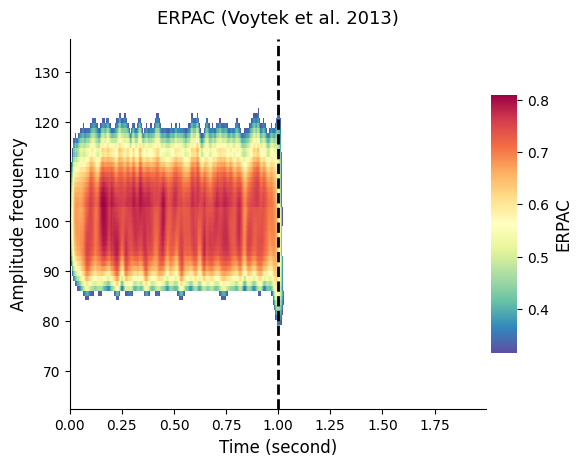

In [35]:
# define an ERPAC object
p = EventRelatedPac(f_pha=[9, 11], f_amp=(60, 140, 5, 1))

# method for correcting p-values for multiple comparisons
mcp = 'bonferroni'
# extract phases and amplitudes
erpac = p.filterfit(sf, x, method='circular', mcp=mcp).squeeze()
# get the p-values and squeeze unused dimensions
pvalues = p.pvalues.squeeze()
# set to nan everywhere it's not significant
erpac[pvalues > .05] = np.nan

vmin, vmax = np.nanmin(erpac), np.nanmax(erpac)

p.pacplot(erpac, time, p.yvec, xlabel='Time (second)',
          cmap='Spectral_r', ylabel='Amplitude frequency', title=p.method,
          cblabel='ERPAC', rmaxis=True, vmin=vmin, vmax=vmax)
plt.axvline(1., linestyle='--', color='k', linewidth=2)

p.show()

In [42]:
print(pvalues)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [43]:
pvalues.shape

(75, 2000)

In [48]:
print(pvalues[0][:1000])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [52]:
for p in pvalues:
        if p.all() != 1.:
                for pp in p:
                        if pp < .05:
                                print(pp)

0.011264725086057581
0.0018210483954117507
0.00027929741852616985
4.284890775529959e-05
6.762573834251384e-06
1.1167233804343368e-06
1.962929818688508e-07
3.7586600498684675e-08
8.043565813409259e-09
1.9984014443252818e-09
5.828670879282072e-10
1.9984014443252818e-10
8.326672684688674e-11
3.3306690738754696e-11
1.6653345369377348e-11
1.6653345369377348e-11
1.6653345369377348e-11
1.6653345369377348e-11
0.0
0.0
1.6653345369377348e-11
1.6653345369377348e-11
1.6653345369377348e-11
1.6653345369377348e-11
3.3306690738754696e-11
3.3306690738754696e-11
6.661338147750939e-11
9.992007221626409e-11
1.4988010832439613e-10
2.498001805406602e-10
4.3298697960381105e-10
7.66053886991358e-10
1.432187701766452e-09
2.864375403532904e-09
6.078471059822732e-09
1.3772316620475067e-08
3.338995746560158e-08
8.644751581243781e-08
2.3897550605056495e-07
7.05152602975545e-07
2.2110813180376e-06
7.327904949505637e-06
2.5455154650799727e-05
9.193327765721904e-05
0.00034197001896885126
0.0012949590399990996
0.00496

Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=75)
    Compute ERPAC (Voytek et al. 2013)
    Correct p-values for multiple-comparisons using bonferroni correction of MNE-Python


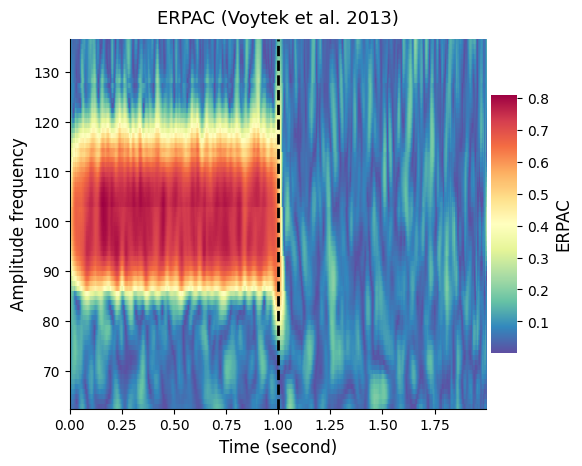

In [17]:
# define an ERPAC object
p = EventRelatedPac(f_pha=[9, 11], f_amp=(60, 140, 5, 1))

# method for correcting p-values for multiple comparisons
mcp = 'bonferroni'
# extract phases and amplitudes
erpac = p.filterfit(sf, x, method='circular', mcp=mcp).squeeze()
# # get the p-values and squeeze unused dimensions
# pvalues = p.pvalues.squeeze()
# # set to nan everywhere it's not significant
# erpac[pvalues > .05] = np.nan

vmin, vmax = np.nanmin(erpac), np.nanmax(erpac)

p.pacplot(erpac, time, p.yvec, xlabel='Time (second)',
          cmap='Spectral_r', ylabel='Amplitude frequency', title=p.method,
          cblabel='ERPAC', rmaxis=True, vmin=vmin, vmax=vmax)
plt.axvline(1., linestyle='--', color='k', linewidth=2)

p.show()